In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from fastai.vision import *

In [4]:
path=untar_data(URLs.MNIST)

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [7]:
defaults.cmap='binary'

In [9]:
sd=il.split_by_folder(train='training',valid='testing')

In [10]:
al=sd.label_from_folder()

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
3, 6, 9, 8, 1...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [12]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [13]:
ll = al.transform(tfms)

In [14]:
bs = 128

In [15]:
data=ll.databunch(bs=bs).normalize()

<b>Convolutional neural network</b>

In [16]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [18]:
model=nn.Sequential(
    conv(1,8), #28->14
    nn.BatchNorm2d(8),
    nn.ReLU(),    
    conv(8, 16), # 14->7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 7->4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 4->2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 2->1
    nn.BatchNorm2d(10),    
    Flatten() # Remove the (1,1) grid
)

In [19]:
learn=Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

In [23]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


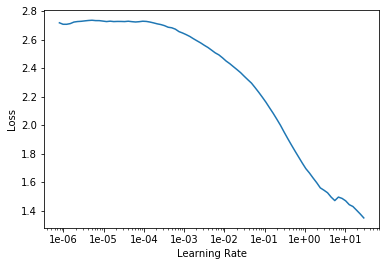

In [22]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.634460,0.150671,0.966990,00:03
1,0.203294,0.048710,0.987864,00:02
2,0.085517,0.055542,0.986893,00:01


Refactoring The Code

In [27]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [29]:
model=nn.Sequential(
conv2(1,8), #28->14
conv2(8,16),#14->7    
conv2(16,32),#7->4
conv2(32,16),#4->2 
conv2 (16,10),#2->1
Flatten()    
)

In [30]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [31]:
learn.fit_one_cycle(5,max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.914101,0.217874,0.945146,00:03
1,0.279958,0.100400,0.974757,00:01
2,0.110635,0.075887,0.979612,00:01
3,0.057970,0.035979,0.990291,00:01
4,0.036178,0.034674,0.992233,00:01


<b>Small ResNet </b>

In [35]:
class ResBlock(nn.Module):
    def __init__(self,nf):
        super().__init__()
        self.conv1=conv_layer(nf,nf,stride=1)
        self.conv2=conv_layer(nf,nf,stride=1)
    def forward(self,x):
        return x + self.conv2(self.conv1(x))

In [37]:
model=nn.Sequential(
    conv2(1,8),#28->14
    res_block(8),#14->14
    conv2(8,16),#14->7
    res_block(16),#7->7
    conv2(16,32),#7->4
    res_block(32),#4->4
    conv2(32,16),#4->2
    res_block(16),#2->2
    conv2(16,10),#2->1
    Flatten()

)

In [38]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


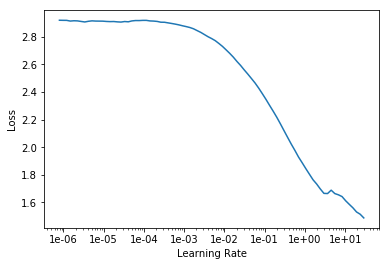

In [41]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(7,max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.027624,0.373655,0.984466,00:04
1,0.312897,0.175350,0.958252,00:02
2,0.119739,0.046230,0.989806,00:02
3,0.058479,0.043120,0.987864,00:02
4,0.037048,0.032031,0.993689,00:02
5,0.024155,0.031408,0.993689,00:02
6,0.017083,0.029031,0.993689,00:02


Refactoring the Code 

In [43]:
def conv_res(ni,nf) : return nn.Sequential(conv2(ni,nf),res_block(nf))

In [44]:
model=nn.Sequential(
    conv_res(1,8),#28->14
    conv_res(8,16),#14->7
    conv_res(16,32),#7->4
    conv_res(32,16),#4->2
    conv_res(16,10),#2->1
    Flatten()
)

In [45]:
learn=Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


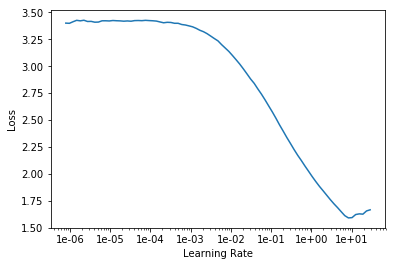

In [47]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(10,max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.836787,0.224646,0.945146,00:03
1,0.249403,0.107738,0.974757,00:02
2,0.108497,0.084949,0.983010,00:02
3,0.054767,0.042540,0.988835,00:02
4,0.038452,0.029419,0.990777,00:02
5,0.027030,0.041655,0.988835,00:02
6,0.027050,0.033179,0.989320,00:02
7,0.018830,0.026339,0.991748,00:02
8,0.015807,0.020993,0.994175,00:02
9,0.010157,0.014591,0.995146,00:02


In [60]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________